In [248]:
%matplotlib inline

In [249]:
from mne_bids import BIDSPath
from pipeline import Pipeline
from preprocessing import *
from erpanalysis import ERPAnalysis
from decoding_analysis import Decoding
import os

In [250]:
bids_root = os.path.join('data', 'P3')
bids_path = BIDSPath(subject='030', session='P3', task='P3',
                        datatype='eeg', suffix='eeg', root=bids_root)

In [251]:
pip = Pipeline(bids_path)

In [252]:

blocks = [ list(range(10*x + 1, 10*x + 6)) for x in range(1, 6)]
l = ['A', 'B', 'C', 'D', 'E']
rare = [ x + i for i, x in enumerate(range(11, 56, 10))]
sstims = [ 'stimulus/'+l[i] +'/' + str(alph) for i, x in enumerate(blocks) for alph in x]
# sstims = ['rare/' + x if int(x.split('/')[-1]) in rare else 'freq/' + x for x in sstims]
sstims_dict = dict((i+3, sstims[i]) for i in range(0, len(sstims)))
sstims_dict[1] = 'response/201'
sstims_dict[2] = 'response/202'

In [253]:
sstims_dict

{3: 'stimulus/A/11',
 4: 'stimulus/A/12',
 5: 'stimulus/A/13',
 6: 'stimulus/A/14',
 7: 'stimulus/A/15',
 8: 'stimulus/B/21',
 9: 'stimulus/B/22',
 10: 'stimulus/B/23',
 11: 'stimulus/B/24',
 12: 'stimulus/B/25',
 13: 'stimulus/C/31',
 14: 'stimulus/C/32',
 15: 'stimulus/C/33',
 16: 'stimulus/C/34',
 17: 'stimulus/C/35',
 18: 'stimulus/D/41',
 19: 'stimulus/D/42',
 20: 'stimulus/D/43',
 21: 'stimulus/D/44',
 22: 'stimulus/D/45',
 23: 'stimulus/E/51',
 24: 'stimulus/E/52',
 25: 'stimulus/E/53',
 26: 'stimulus/E/54',
 27: 'stimulus/E/55',
 1: 'response/201',
 2: 'response/202'}

In [254]:
pip.load_data()
# pip.apply_resampling(512)
pip.set_custom_events_mapping(mapping=sstims_dict)
pip.set_montage()
pip.apply_cleaning(CleaningData(bids_path))
pip.apply_filter(SimpleMNEFilter(0.1, 50, 'firwin'))
# pip.apply_ica(PrecomputedICA(bids_path))

# pip.apply_rereferencing('average')
# pip.apply_ica(SimpleMNEICA('fastica', exclude=[0,1, 2]))

INFO:root:Loading Data
INFO:root:Setting montage
INFO:root:Applying cleaning
/Users/ssaurabh/Projects/eeg-pipeline/preprocessing.py:95: UserWarning: loadtxt: Empty input file: "data/P3/sub-030/ses-P3/eeg/sub-030_ses-P3_task-P3_badChannels.tsv"
  bad_channels = np.loadtxt(ch_fname, delimiter='\t', dtype='int')
INFO:root:Applying filtering


In [255]:
pip.event_ids

{'response/201': 1,
 'response/202': 2,
 'stimulus/A/11': 3,
 'stimulus/A/12': 4,
 'stimulus/A/13': 5,
 'stimulus/A/14': 6,
 'stimulus/A/15': 7,
 'stimulus/B/21': 8,
 'stimulus/B/22': 9,
 'stimulus/B/23': 10,
 'stimulus/B/24': 11,
 'stimulus/B/25': 12,
 'stimulus/C/31': 13,
 'stimulus/C/32': 14,
 'stimulus/C/33': 15,
 'stimulus/C/34': 16,
 'stimulus/C/35': 17,
 'stimulus/D/41': 18,
 'stimulus/D/42': 19,
 'stimulus/D/43': 20,
 'stimulus/D/44': 21,
 'stimulus/D/45': 22,
 'stimulus/E/51': 23,
 'stimulus/E/52': 24,
 'stimulus/E/53': 25,
 'stimulus/E/54': 26,
 'stimulus/E/55': 27}

In [256]:

erp = ERPAnalysis(-0.1, 0.8)
df = pip.compute_erp_peak(erp, 'stimulus', 0.450, 0.150, ['Cz'])

INFO:root:Trial 0: peak of -754 µV and mean of -1106 µV at 300 ms in channel Cz
INFO:root:Trial 1: peak of -78 µV and mean of -103 µV at 439 ms in channel Cz
INFO:root:Trial 2: peak of 123 µV and mean of 85 µV at 529 ms in channel Cz
INFO:root:Trial 3: peak of 164 µV and mean of 118 µV at 597 ms in channel Cz
INFO:root:Trial 4: peak of 98 µV and mean of 67 µV at 599 ms in channel Cz
INFO:root:Trial 5: peak of 90 µV and mean of 70 µV at 555 ms in channel Cz
INFO:root:Trial 6: peak of 45 µV and mean of 23 µV at 559 ms in channel Cz
INFO:root:Trial 7: peak of 19 µV and mean of -4 µV at 315 ms in channel Cz
INFO:root:Trial 8: peak of 40 µV and mean of 15 µV at 547 ms in channel Cz
INFO:root:Trial 9: peak of 19 µV and mean of 0 µV at 366 ms in channel Cz
INFO:root:Trial 10: peak of 76 µV and mean of 40 µV at 593 ms in channel Cz
INFO:root:Trial 11: peak of 51 µV and mean of 37 µV at 466 ms in channel Cz
INFO:root:Trial 12: peak of 6 µV and mean of -24 µV at 324 ms in channel Cz
INFO:root:Tr

In [262]:

epoch_train = erp.epochs['stimulus/B'].copy()
# epoch_train = epoch_train.crop(tmin=0.1, tmax=0.5,)
dec = Decoding(epoch_train)
dec.train(['Cz', 'CPz'])
data, labels = dec.get_data()
# labels = np.where(np.isin(labels, rare), 1, 2)
rare

[11, 22, 33, 44, 55]

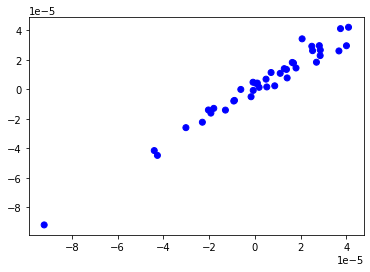

In [258]:
import matplotlib.pyplot as plt
plt.scatter(data[:,0],data[:,1], color=np.array(["red", "blue"])[np.where(labels == 1,0, 1)]);

In [259]:
csp = mne.decoding.CSP(n_components=2)
csp.fit_transform(epoch_train.get_data(), labels)
csp.plot_filters(epoch_train.info);
csp.plot_patterns(epoch_train.info);

ValueError: n_classes must be >= 2.

In [ ]:
labels.sort()
rare = [3,9,15,21,27]
# np.isin(labels, rare)

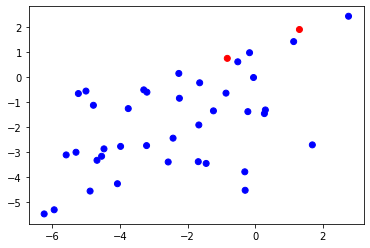

In [ ]:
csp_data = csp.transform(epoch_train.get_data())
plt.scatter(csp_data[:,0],csp_data[:,1],color=np.array(["red", "blue"])[np.where(labels == 1,0, 1)]);

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
flattenData = csp_data.reshape(csp_data.shape[0],-1)

lda.fit(flattenData, labels) # fit on training
print(lda.score(flattenData,labels))

0.95


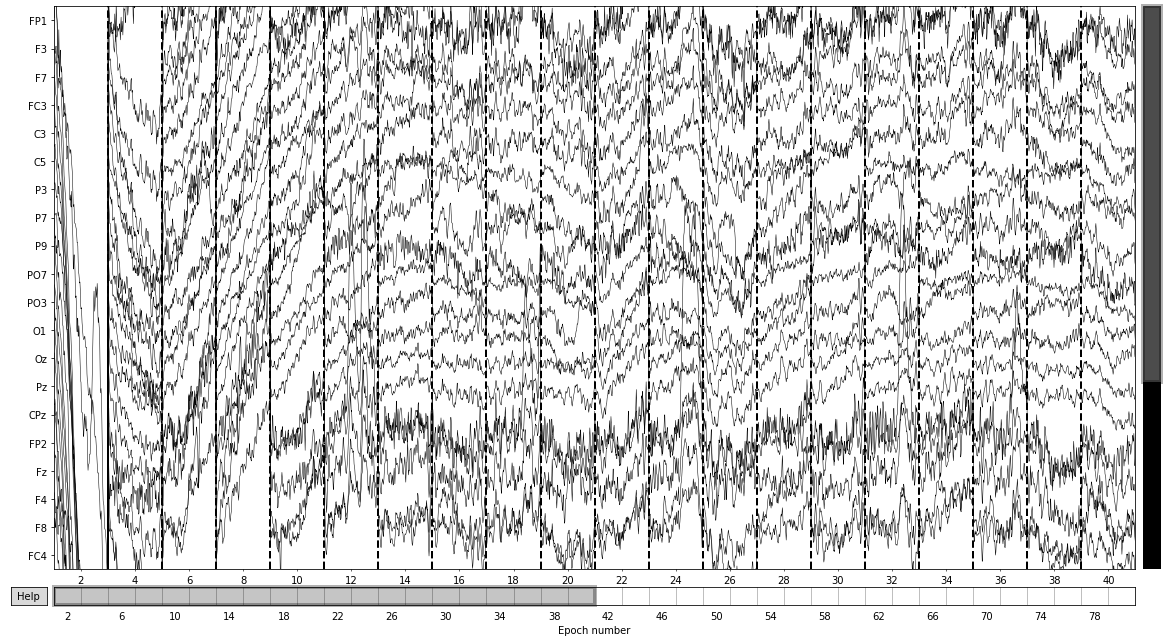

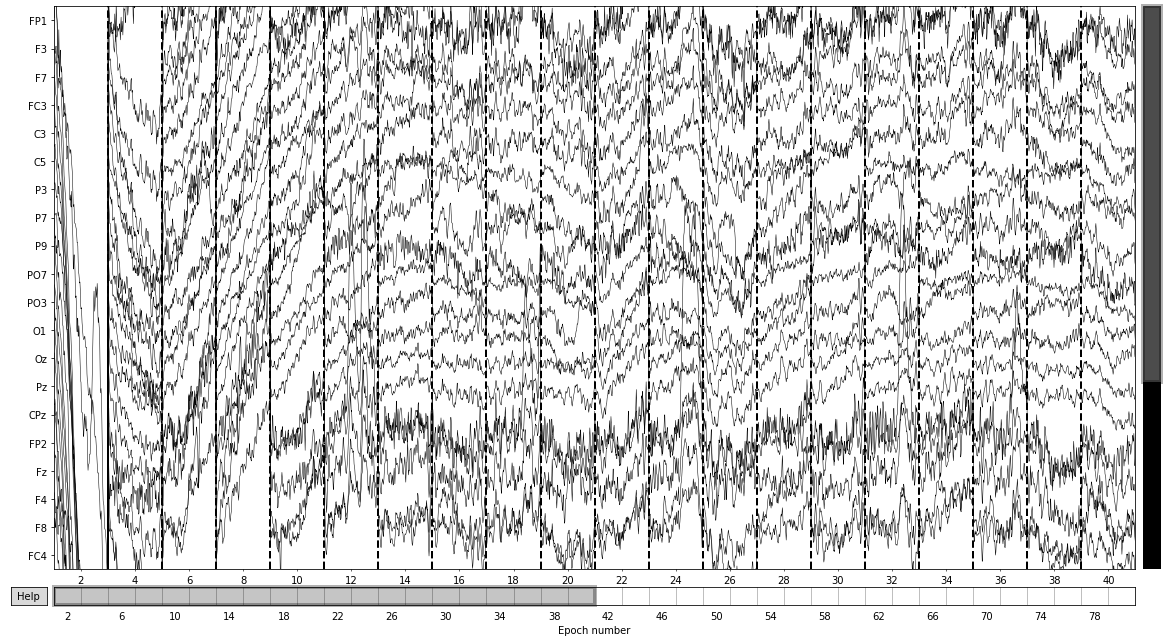

In [ ]:

# stim_ba = mne.pick_events(pip.events, include=[3,4,5,6,7])
event_dict = {'A/rare/11': 3, 'A/freq/12': 4, 'A/freq/13':5, 'A/freq/14':6, 'A/freq/15':7}
# event_dict = {'D/rare/18': 18, 'D/freq/19': 19, 'D/freq/20':20, 'D/freq/21':21, 'D/freq/22':22}
# _epochs = mne.Epochs(pip.raw, stim_ba, event_dict, tmin=-0.1,tmax=0.8, reject_by_annotation=False).copy()
erp.compute_epochs(pip.raw, pip.events, pip.event_ids)
pip.event_ids
# print(_epochs)
erp.epochs['stimulus/C'].plot()
# mne.viz.plot_compare_evokeds({'A': _epochs.average(), 'resp': erp.epochs['stimulus/A'].average()}, picks='Cz')

In [ ]:
df.describe()

peak_amp     mean_amp     latency       trial
count  200.000000   200.000000  200.000000  200.000000
mean    31.430000     1.320000  472.780000   99.500000
std     83.744317    95.919447   92.876974   57.879185
min   -754.000000 -1106.000000  300.000000    0.000000
25%      6.750000   -16.000000  386.750000   49.750000
50%     25.000000     3.000000  481.000000   99.500000
75%     47.000000    21.250000  555.500000  149.250000
max    409.000000   315.000000  599.000000  199.000000

In [ ]:
# df[df['channel'] == 'Cz']
bltrials = [list(range( 10+x, 60+x, 10)) for x in range(1,6)]
l = ['A', 'B', 'C', 'D', 'E']
stims = [ 'stimulus'+'/'+str(alph)+'/'+l[i] for i, x in enumerate(bltrials) for alph in x]
stdicts = dict((l[i], arr) for i, arr in enumerate(bltrials))
# stims
stim_a = [ 'stimulus/' + str(x) for x in bltrials[0]]
stim_b = [ 'stimulus/' + str(x) for x in bltrials[1]]
stim_c = [ 'stimulus/' + str(x) for x in bltrials[2]]
stim_d = [ 'stimulus/' + str(x) for x in bltrials[3]]
stim_e = [ 'stimulus/' + str(x) for x in bltrials[4]]

stim_a_dict = dict((k, pip.event_ids[k]) for k in stim_a)
stim_b_dict = dict((k, pip.event_ids[k]) for k in stim_b)
stim_c_dict = dict((k, pip.event_ids[k]) for k in stim_c)
stim_d_dict = dict((k, pip.event_ids[k]) for k in stim_d)
stim_e_dict = dict((k, pip.event_ids[k]) for k in stim_e)
# stim_a_dict = { stim_a[0]: pip.event_ids[stim_a[0]]}
stim_b_dict
# tblocks = np.array([list(range( 10*x +1, 50+x, 10) for x in range(1,6))], dtype=float)

KeyError: 'stimulus/11'

In [ ]:

blocks = np.array([ list(range(10*x + 1, 10*x + 6)) for x in range(1, 6)])
rare = np.array([ x + i for i, x in enumerate(range(11, 56, 10))]).tolist()
freq = np.setdiff1d(blocks.flatten(), rare).tolist()

In [ ]:
pip.event_ids.keys()

In [ ]:
rare = ['stimulus/' + str(i) for i in rare]
freq = ['stimulus/' + str(i) for i in freq]

In [ ]:
rare_dict = dict((k, pip.event_ids[k]) for k in rare)
freq_dict = dict((k, pip.event_ids[k]) for k in freq)

In [ ]:
rare_epochs = mne.Epochs(pip.raw,pip.events, rare_dict,tmin=-0.2,tmax=0.8, reject_by_annotation=False).copy()
freq_epochs = mne.Epochs(pip.raw,pip.events, freq_dict,tmin=-0.2,tmax=0.8, reject_by_annotation=False).copy()


In [ ]:
mne.viz.plot_compare_evokeds({'rare': rare_epochs.average(), 'freq': freq_epochs.average()}, picks='Cz')

In [ ]:
pip.event_ids

In [ ]:

stim_ba = mne.pick_events(pip.events, include=[3,4,5,6,7])
event_dict = {'A/rare/11': 3, 'A/freq/12': 4, 'A/freq/13':5, 'A/freq/14':6, 'A/freq/15':7}
# event_dict = {'D/rare/18': 18, 'D/freq/19': 19, 'D/freq/20':20, 'D/freq/21':21, 'D/freq/22':22}
_epochs = mne.Epochs(pip.raw, stim_ba, event_dict, tmin=-0.1,tmax=0.8, reject_by_annotation=False).copy()
pip.set_custom_events_mapping(sstims_dict)
erp.compute_epochs(pip.raw, pip.events, pip.event_ids)
pip.event_ids
# print(_epochs)
# erp.epochs['stimulus/D']
mne.viz.plot_compare_evokeds({'E':  erp.epochs['stimulus/D'].average(), 'A': erp.epochs['stimulus/A'].average()}, picks='Cz')

In [ ]:
wanted_keys = [e for e in pip.event_ids.keys() if "stimulus" in e]
evts_dict_stim=dict((k, pip.event_ids[k]) for k in wanted_keys if k in pip.event_ids)

# get epochs with and without rejection
epochs = mne.Epochs(pip.raw, pip.events, evts_dict_stim,tmin=-0.1,tmax=0.8, reject_by_annotation=False)
mne.viz.plot_compare_evokeds({'stim': epochs['stimulus'].average(), 'resp': erp.epochs['stimulus'].average(), 'cust': _epochs['stimulus'].average()}, picks='Cz')

In [ ]:
a_epochs = mne.Epochs(pip.raw,pip.events, stim_a_dict,tmin=-0.2,tmax=0.8, reject_by_annotation=False, baseline=(0, None)).copy()
b_epochs = mne.Epochs(pip.raw,pip.events, stim_b_dict,tmin=-0.2,tmax=0.8, reject_by_annotation=False).copy()
c_epochs = mne.Epochs(pip.raw,pip.events, stim_c_dict,tmin=-0.2,tmax=0.8, reject_by_annotation=False).copy()
d_epochs = mne.Epochs(pip.raw,pip.events, stim_d_dict,tmin=-0.2,tmax=0.8, reject_by_annotation=False).copy()
e_epochs = mne.Epochs(pip.raw,pip.events, stim_e_dict,tmin=-0.2,tmax=0.8, reject_by_annotation=False).copy()
mne.viz.plot_compare_evokeds({'A': a_epochs.average(), 'B': b_epochs.average(), 'C': a_epochs.average(), 'D': d_epochs.average(), 'E': e_epochs.average()}, picks='Cz')